## Cleaning and preprocessing of raw data

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout

import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

# Define directories for each dataset
directories = [
    'agoda_hotel_reviews',  
    'tripadvisor_hotel_reviews',
    'klook_hotel_reviews',  
    'booking_hotel_reviews'
]

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Function to load and normalize data
def load_and_normalize_data(directories):
    hotel_dfs = {}
    
    for directory in directories:           
        path = os.path.join('../raw data', directory)
        
        for filename in os.listdir(path):
            if filename.endswith('.csv'):
                # Extract hotel name from filename by removing undesired part
                hotel_name = os.path.splitext(filename)[0].replace('_reviews_2022_2024', '')
                
                df = pd.read_csv(os.path.join(path, filename))
                
                # Normalize the Review Score
                scaler = MinMaxScaler(feature_range=(0, 1))
                df['normalized_score'] = scaler.fit_transform(df[['Review Score']])

                # Add a new column for hotel name
                df['Hotel'] = hotel_name
                
                # Concatenate to the hotel DataFrame
                if hotel_name in hotel_dfs:
                    hotel_dfs[hotel_name] = pd.concat([hotel_dfs[hotel_name], df], ignore_index=True)
                else:
                    hotel_dfs[hotel_name] = df.reset_index(drop=True)

    return hotel_dfs


In [3]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import DetectorFactory
DetectorFactory.seed = 0

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    try:
        #Return None if there are less than 10 words in the review
        min_length = 10
        if len(text.split()) < min_length:
            return None
        # Check if the review is in English
        lang = detect(text)
        if lang != 'en':
            return None  # Return None if not in English
        # Convert text to lowercase
        
        text = text.lower()

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove emojis
        text = re.sub(r'[^\w\s]', '', text)

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Tokenization
        tokens = nltk.word_tokenize(text)
        # Count tokens before removing stop words and lemmatization
        num_tokens_before = len(tokens)

        # Remove stop words
        tokens = [word for word in tokens if word not in stop_words]
        num_tokens_after_stopwords = len(tokens)

        # Lemmatization
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
        num_tokens_after_lemmatization = len(lemmatized_tokens)

        # Add token counts to the DataFrame
        df.loc[df['Review Content'] == text, 'num_tokens_before'] = num_tokens_before
        df.loc[df['Review Content'] == text, 'num_tokens_after_stopwords'] = num_tokens_after_stopwords
        df.loc[df['Review Content'] == text, 'num_tokens_after_lemmatization'] = num_tokens_after_lemmatization

        # Return the processed text as a single string
        return ' '.join(lemmatized_tokens)

    except LangDetectException as e:
        # If language detection fails, return None
        # print(f"error: {e}")
        return None

# Load and normalize data
hotel_dfs = load_and_normalize_data(directories)


# Example usage with your DataFrame
rows_before_preprocessing = 0

for hotel, df in hotel_dfs.items():
    # Apply preprocessing to the DataFrame's 'Review Content' column
    df['cleaned_content'] = df['Review Content'].apply(preprocess_text)


In [4]:
total = 0

rows_before_preprocessing = 0
rows_after_preprocessing = 0

for hotel, df in hotel_dfs.items():
    num = df['cleaned_content'].isnull().sum()
    rows = df.shape[0]
    
    total += num
    rows_before_preprocessing += rows
    rows_after_preprocessing += rows - num
    print(f"Hotel: {hotel}")
    print(f"Number of reviews before preprocessing: {rows}")
    print(f"Number of removed reviews: {num}")
    print(f"Number of remaining reviews: {rows - num}")
    print()

print(f"Total rows before preprocessing: {rows_before_preprocessing}")
print(f"Total rows after preprocessing: {rows_after_preprocessing}")

    
print(f"Total removed reviews :{total}")


Hotel: bai_hotel
Number of reviews before preprocessing: 4039
Number of removed reviews: 1234
Number of remaining reviews: 2805

Hotel: dusit_thani_mactan
Number of reviews before preprocessing: 1888
Number of removed reviews: 357
Number of remaining reviews: 1531

Hotel: fairfield_by_marriott_cebu
Number of reviews before preprocessing: 107
Number of removed reviews: 26
Number of remaining reviews: 81

Hotel: jpark_island_resort_and_waterpark
Number of reviews before preprocessing: 555
Number of removed reviews: 189
Number of remaining reviews: 366

Hotel: seda_ayala_center_cebu
Number of reviews before preprocessing: 1966
Number of removed reviews: 685
Number of remaining reviews: 1281

Hotel: waterfront_hotel_and_casino
Number of reviews before preprocessing: 1687
Number of removed reviews: 683
Number of remaining reviews: 1004

Total rows before preprocessing: 10242
Total rows after preprocessing: 7068
Total removed reviews :3174


In [19]:
#creation of labels
input_data_dfs = {}
for hotel, df in hotel_dfs.items():
    df['label'] = df['normalized_score'].apply(lambda x: 0 if x <= 0.25 else (2 if x >= 0.75 else 1))
    # Identify and print the removed reviews (non-English)
    removed_reviews = df[df['cleaned_content'].isnull()]['Review Content']
    # Drop rows where 'cleaned_content' is None (non-English reviews)
    df = df.dropna(subset=['cleaned_content'])
    

    # Update the DataFrame in the dictionary
    input_data_dfs[hotel] = df
for hotel, df in input_data_dfs.items():
    print(f"Hotel: {hotel}")
    print(df.shape[0])
    print()

Hotel: bai_hotel
2805

Hotel: dusit_thani_mactan
1531

Hotel: fairfield_by_marriott_cebu
81

Hotel: jpark_island_resort_and_waterpark
366

Hotel: seda_ayala_center_cebu
1281

Hotel: waterfront_hotel_and_casino
1004



In [20]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Initialize combined lists
combined_X_train = []
combined_y_train = []

raw_train_data = {}
raw_test_data = {}



for hotel_name, df in input_data_dfs.items():
    # Split the dataset into training and testing sets
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        df['cleaned_content'], 
        df['label'], 
        test_size=0.3, 
        stratify=df['label'], 
        random_state=42
    )
    
    # Store raw train/test data
    raw_train_data[hotel_name] = (X_train_raw, y_train)
    raw_test_data[hotel_name] = (X_test_raw, y_test)

    # Add to combined lists
    combined_X_train.extend(X_train_raw)  # Use extend to flatten the list for strings
    combined_y_train.extend(y_train.tolist())  # Ensure y_train is a list to extend it
    
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(combined_X_train)  # Fit tokenizer on combined training data

# Convert texts to sequences
X_train_sequences = tokenizer.texts_to_sequences(combined_X_train)
X_test_sequences = []

# Optionally convert test texts into sequences for padding later
for hotel_name, (test_data, _) in raw_test_data.items():
    sequences = tokenizer.texts_to_sequences(test_data)
    X_test_sequences.append(sequences)

# Pad sequences to ensure uniform input size
X_train_padded = pad_sequences(X_train_sequences, maxlen=100)

# Pad test sequences for each hotel
X_test_padded = []
for sequences in X_test_sequences:
    padded_sequences = pad_sequences(sequences, maxlen=100)
    X_test_padded.append(padded_sequences)
    
# Shuffle the padded training data and corresponding labels
X_train_padded, combined_y_train = shuffle(X_train_padded, combined_y_train, random_state=42)

# Store the processed data in a combined format if desired
train_data = (X_train_padded, np.array(combined_y_train))  # Now a tuple of padded data and labels


# Prepare test data dictionary if needed
test_data = {}
for i, hotel_name in enumerate(raw_test_data.keys()):
    test_data[hotel_name] = X_test_padded[i], raw_test_data[hotel_name][1]  # Corresponding labels    





In [21]:
# Model creation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Model creation
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes for multi-class classification
])

# Model Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

X_train_padded, y_train = train_data
# Model Training
history = model.fit(
    X_train_padded, 
    y_train, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping]
)

Epoch 1/10


c:\Users\Predator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.7739 - loss: 0.9478 - val_accuracy: 0.7947 - val_loss: 0.6816
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8004 - loss: 0.7004 - val_accuracy: 0.7947 - val_loss: 0.6691
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8002 - loss: 0.6783 - val_accuracy: 0.7947 - val_loss: 0.6253
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8044 - loss: 0.5932 - val_accuracy: 0.8291 - val_loss: 0.5013
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8541 - loss: 0.4355 - val_accuracy: 0.8231 - val_loss: 0.5017
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.8691 - loss: 0.3772 - val_accuracy: 0.8301 - val_loss: 0.5384
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9011 - loss: 0.3222 - val_accuracy: 0.8261 - val_loss: 0.5565


Test Accuracy for bai_hotel: 0.9181
Test Loss for bai_hotel: 0.2884
Test Accuracy for dusit_thani_mactan: 0.7870
Test Loss for dusit_thani_mactan: 0.5645
Test Accuracy for fairfield_by_marriott_cebu: 0.7200
Test Loss for fairfield_by_marriott_cebu: 0.9776
Test Accuracy for jpark_island_resort_and_waterpark: 0.7455
Test Loss for jpark_island_resort_and_waterpark: 0.6027
Test Accuracy for seda_ayala_center_cebu: 0.8442
Test Loss for seda_ayala_center_cebu: 0.5042
Test Accuracy for waterfront_hotel_and_casino: 0.6689
Test Loss for waterfront_hotel_and_casino: 0.7834


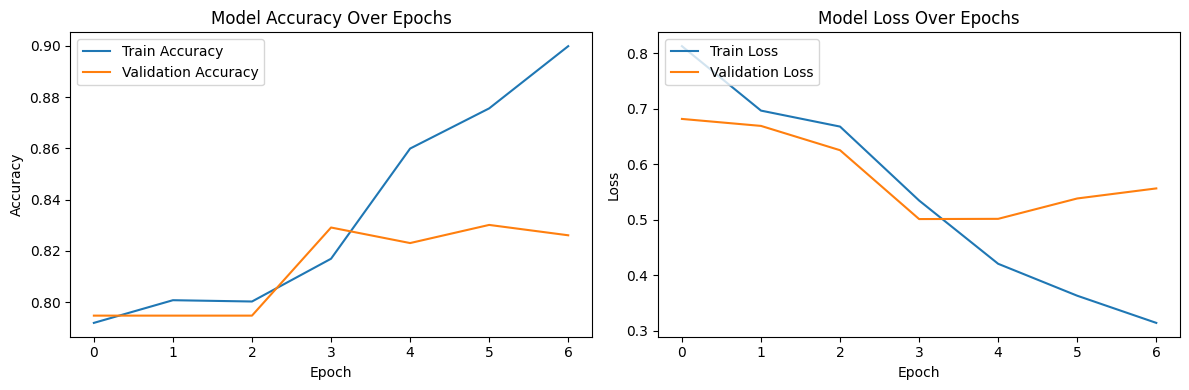

In [22]:

# Model Evaluation
# Note: Ensure to prepare X_test and y_test from your test data dictionary created earlier
results = {}
for hotel_name, (X_test, y_test) in test_data.items():
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results[hotel_name] = {'accuracy': accuracy, 'loss': loss}
    print(f'Test Accuracy for {hotel_name}: {accuracy:.4f}')
    print(f'Test Loss for {hotel_name}: {loss:.4f}')


# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' is the dictionary storing the accuracy and loss for each hotel
# Example structure: results = {'Hotel A': {'accuracy': 0.85, 'loss': 0.45}, ... }

# Extract hotel names, accuracies, and losses from the results dictionary
hotels = list(results.keys())
accuracy = [results[hotel]['accuracy'] for hotel in hotels]
loss = [results[hotel]['loss'] for hotel in hotels]

# Plot the accuracy and loss using a bar chart
x = np.arange(len(hotels))  # the label locations

plt.figure(figsize=(14, 6))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.bar(x - 0.2, accuracy, 0.4, label='Accuracy', color='skyblue')
plt.xticks(x, hotels, rotation=45)
plt.ylim(0, 1)  # Set y-axis limits for accuracy
plt.xlabel('Hotels')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Across Hotels')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.bar(x + 0.2, loss, 0.4, label='Loss', color='salmon')
plt.xticks(x, hotels, rotation=45)
plt.ylim(0, max(loss) + 0.1)  # Adjust the y-axis limit for loss
plt.xlabel('Hotels')
plt.ylabel('Loss')
plt.title('Test Loss Across Hotels')
plt.legend()

# Adjust layout for better readability
plt.tight_layout()
plt.show()


In [ ]:
# # Count the number of cleaned reviews per hotel
# cleaned_reviews_count = {hotel: df['cleaned_content'].notnull().sum() for hotel, df in hotel_dfs.items()}

# # Print the counts
# for hotel, count in cleaned_reviews_count.items():
#     print(f"{hotel}: {count} cleaned reviews")

In [ ]:
# import os
# import pandas as pd
# import numpy as np

# output_dir = 'predictions_by_hotel'
# os.makedirs(output_dir, exist_ok=True)

# for hotel_name, (X_test, y_test) in test_data.items():
#     # Evaluate the model
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'Test Accuracy for {hotel_name}: {accuracy:.4f}')
    
#     # Make predictions
#     predicted_scores = model.predict(X_test)  # Predicted scores give probabilities for each class
    
    
    
#     # Convert predicted probabilities to class labels
#     predicted_classes = np.argmax(predicted_scores, axis=1)  # Get index of max probability for each sample
#     # Create a DataFrame to store true labels and predicted labels
#     predictions = {
#         'true_label': y_test,
#         'predicted_class': predicted_classes,
#         'predicted_scores': predicted_scores.tolist()  # Store the original probabilities if needed
#     }
    
#     # Convert to DataFrame
#     predictions_df = pd.DataFrame(predictions)
    
#     # Add hotel name to the DataFrame
#     predictions_df['hotel_name'] = hotel_name
    
#     # Save predictions to a CSV file, named after the hotel
#     predictions_filename = os.path.join(output_dir, f'{hotel_name}_predictions.csv')
#     predictions_df.to_csv(predictions_filename, index=False)

#     print(f'Predictions for {hotel_name} saved to {predictions_filename}')

In [ ]:
# import numpy as np
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Example input reviews
# new_reviews = [
#     {"review": "The hotel staff was incredibly helpful and the room was clean and spacious. Definitely a positive experience!", "score": 1.0},
#     {"review": "The location was good, but the room had a strange smell and the service was just okay.", "score": 0.6},
#     {"review": "I had a terrible stay. The room was dirty and the staff was rude. Not worth the price.", "score": 0.2},
#     {"review": "Amazing experience! The view from the room was breathtaking and the food at the restaurant was top-notch.", "score": 1.0},
#     {"review": "The room was decent, but the Wi-Fi was slow and unreliable. It was an average stay overall.", "score": 0.5},
#     {"review": "Terrible service! We waited over an hour for our room to be ready and the staff was not apologetic.", "score": 0.3},
#     {"review": "The hotel was in a perfect location, close to all the major attractions. The room was comfortable and well-maintained.", "score": 0.9},
#     {"review": "The facilities were outdated, and the air conditioning barely worked. I was disappointed with my stay.", "score": 0.4},
#     {"review": "Great value for money! The hotel offered a lot of amenities and the staff was very friendly.", "score": 0.8},
#     {"review": "The breakfast was good, but the room was small and the bed was uncomfortable. It was an okay stay.", "score": 0.6}
# ]

# # Define a function to preprocess new input data
# def preprocess_new_data(new_data):
#     # Apply the same preprocessing function
#     cleaned_data = [preprocess_text(entry["review"]) for entry in new_data]
    
#     # Convert to sequences using the trained tokenizer
#     sequences = tokenizer.texts_to_sequences(cleaned_data)
    
#     # Pad the sequences
#     padded_sequences = pad_sequences(sequences, maxlen=100)  # Use the same maxlen as your training data

#     return padded_sequences

# # Prepare reviews for prediction
# padded_sequences = preprocess_new_data(new_reviews)

# # Make predictions
# predictions = model.predict(padded_sequences)

# # Interpreting the predictions
# for i, prediction in enumerate(predictions):
#     predicted_label = np.argmax(prediction)  # Get the index of the highest probability
#     predicted_score = prediction[predicted_label]  # The probability of the predicted class
#     actual_score = new_reviews[i]["score"]

#     # Assign sentiment based on the predicted label
#     sentiment_labels = ['Negative', 'Neutral', 'Positive']
#     sentiment = sentiment_labels[predicted_label]

#     # Print the results
#     print(f"Review: {new_reviews[i]['review']}")
#     print(f"Actual Score: {actual_score:.2f}")
#     print(f"Predicted Label: {sentiment}")
#     print(f"Negative Probability: {prediction[0]:.2f}")
#     print(f"Neutral Probability: {prediction[1]:.2f}")
#     print(f"Positive Probability: {prediction[2]:.2f}")
#     print("-" * 50)

In [ ]:
# from datetime import datetime
# import os

# # Assuming `model` is your Keras model
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# file_name = f'saved_models/General_Sen_{timestamp}.keras'

# # Make sure the directory exists
# os.makedirs(os.path.dirname(file_name), exist_ok=True)

# # Save the model with the unique file name
# model.save(file_name)
# print(f"Model saved as {file_name}")
# model.summary()